# Basic tutorial on how to use the module `basilpy`

In [2]:
import basilpy as bs

We import some standard pyhton modules

In [223]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rc('xtick', labelsize=20)   
plt.rc('ytick', labelsize=20)
#plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=25)

## 1. Ignoring the signal/background likelihoods

The most import class of `basilpy` is

`OnOffMeasurement`

This class allow to handle ON/OFF measurment and estimated the signal

Let' see one example. For now we will ingore the likelihoods for each event of being a signal or background

In [234]:
Non   = 22
Noff  = 50
alpha = 0.2
m1    = bs.OnOffMeasurement( Non, Noff, alpha)

In [235]:
print(m1)

OnOffMeasurement
----------------

  Non                             :  22 
  Noff                            :  50 
  Alpha                           :  0.2 

  Excess                          :  12.0 
  Error Excess                    :  4.898979485566356 
  Li&Ma Significance              :  2.9047925360855653 




The object `m1` is an ON/OFF measurement from which we can already get some information on the excess and its significance computed with the standard Li&Ma formula

We the function `run` we can now compute the PMF of the number of signal events and the signal PDF

In [236]:
%%time
m1.run()

CPU times: user 262 ms, sys: 18.1 ms, total: 280 ms
Wall time: 264 ms


In [237]:
print(m1)

OnOffMeasurement
----------------

  Non                             :  22 
  Noff                            :  50 
  Alpha                           :  0.2 

  Excess                          :  12.0 
  Error Excess                    :  4.898979485566356 
  Li&Ma Significance              :  2.9047925360855653 

  Most probable signal            :  11.90164303092625 
  Expected signal                 :  12.818218456199075 
  Root mean squared               :  3.5802539653213254 



Did you notice?

The most probable signal is different from the excess, which is also different from the expected signal

This is because the PDF of the signal is not simmetric (negative values do not make any sense)

We can plot the PDF and the PMF as shown below

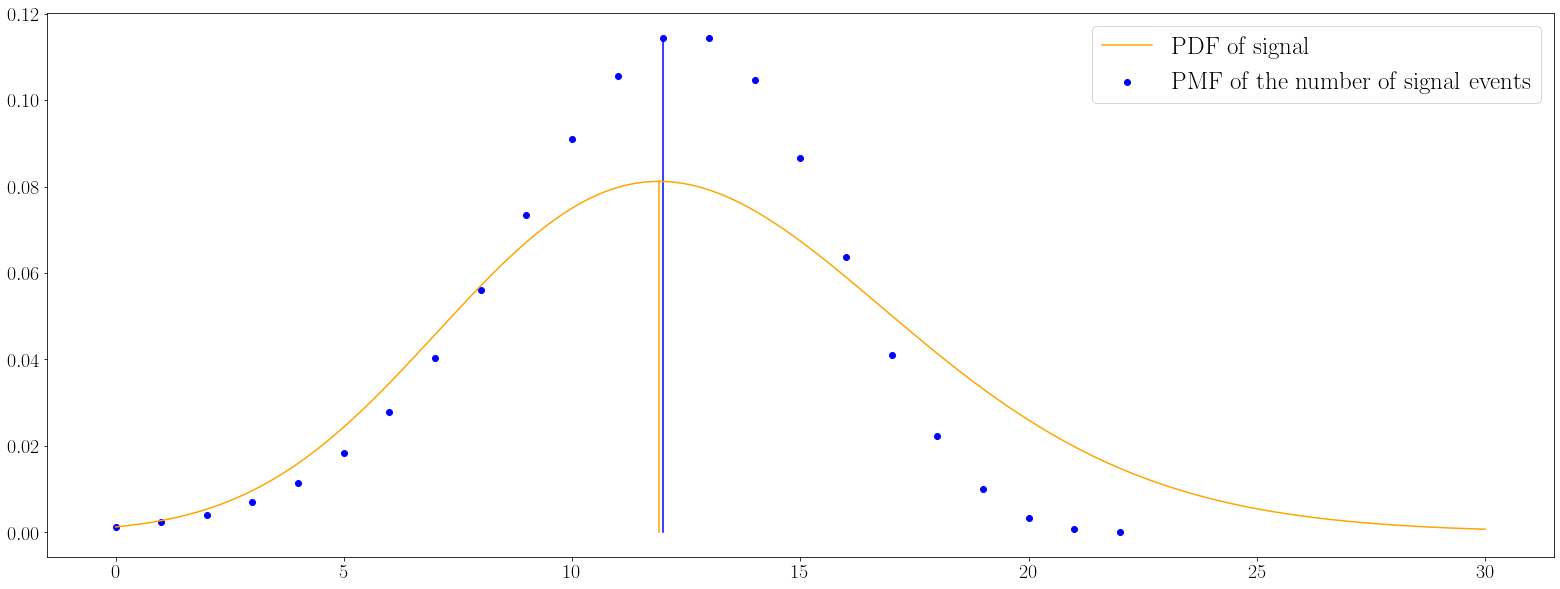

In [238]:
fig, ax = plt.subplots(figsize=(27,10),nrows=1, ncols=1)
# PLOT PMF
ax.scatter( m1.Ns, m1.pmf, label = "PMF of the number of signal events", c="blue")
ax.plot( (m1.mode_pmf,m1.mode_pmf), (0,m1.pmf[m1.Ns==m1.mode_pmf][0]), c="blue")
# PLOT PDF
s = np.linspace(0,30,1000)
ax.plot( s, m1.pdf(s), label = "PDF of signal", c="orange" )
ax.plot( (m1.mode_pdf,m1.mode_pdf), (0,m1.pdf(m1.mode_pdf)), c="orange")

ax.legend()

We can now compute the 95% upeer limit (UL) ...

In [239]:
%%time
UL = m1.upper_limit( 0.95 )
UL

CPU times: user 63.3 ms, sys: 2.8 ms, total: 66.1 ms
Wall time: 64.6 ms


21.510562474446274

... or the 68% credible interval (CI) to not be confused with the frequentist confidence interval

In [240]:
%%time
CI_low, CI_up = m1.credible_interval()
CI_low, CI_up 

CPU times: user 3.34 s, sys: 16.1 ms, total: 3.36 s
Wall time: 3.36 s


(7.2588843228967, 17.100166862070044)

Below a visualization of the UL and CI just computed

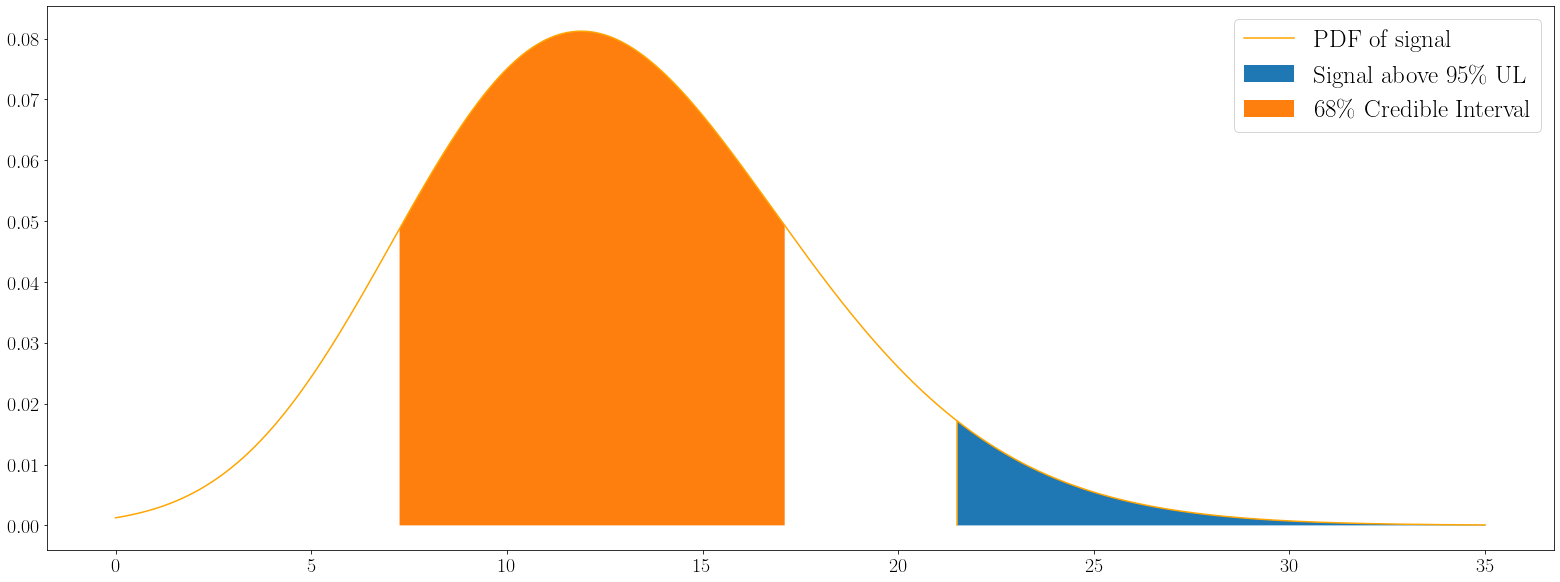

In [241]:
fig, ax = plt.subplots(figsize=(27,10),nrows=1, ncols=1)
# PLOT PDF
s = np.linspace(0,35,1000)
ax.plot( s, m1.pdf(s), label = "PDF of signal", c="orange" )
ax.plot( (UL,UL), (0,m1.pdf(UL)), c="orange")
#SHOW UL
x = np.linspace(UL,35,1000)
y = m1.pdf(x)
ax.fill_between(x,y, label="Signal above 95\% UL")
#SHOW CI
x = np.linspace(CI_low,CI_up,1000)
y = m1.pdf(x)
ax.fill_between(x,y, label="68\% Credible Interval")

ax.legend()

## 1. Including the signal/background likelihoods

We now want to include the information about the **likelihood** of being a signal or background event of each single event

For this purpose we define a *Toy Model* in which we have observed for each event a discrimintaing variable `x` which can take values between 0 and 1

Observations of `x` from a **signal population** are distribuited as

$$
N \frac{1}{(a+x)^2}
$$

with $N = a(1+a)$ a normalization factor

Observations of `x` from a **background population** have instead a unifrom distribution

We therefore define 2 functions `signal_pdf` and `bkg_pdf`

Below you can play with the values of $a$

In [255]:
a          = 0.2
normfact   = a**2+a
signal_pdf = lambda x: 1/(a+x)**2 * normfact
bkg_pdf    = lambda x: np.ones_like(x)

It is now time to generate the `observed_x`, i.e. the observed values of `x` for each of the $N_{on}$ event

Feel free to change how to get `observed_x`. Below for instance we will assumed that all events come from a signal poulation

In [256]:
# Generate the observed x accoridng to the bkg hypothesis, or ....
# observed_x = np.random.uniform(0,1,Non)
# .... generate the observed x accoridng to the bkg hypothesis
signal_invcdf = lambda u: a**2*u/( normfact- a*u)
observed_x = signal_invcdf( np.random.uniform(0,1,Non) )

We now plot the functions `signal_pdf` and `bkg_pdf` along with the observed `x` (vertical lines)

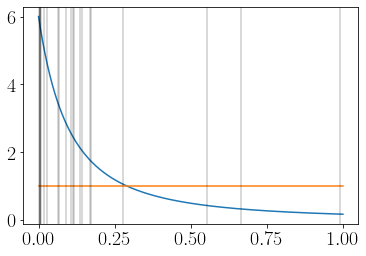

In [257]:
x = np.linspace(0,1,1000)
plt.plot(x, signal_pdf(x))
plt.plot(x, bkg_pdf(x))
for ix in observed_x:
    plt.axvline( ix, 0, 1, c="black", alpha=0.2)

We can now compute from the `observed_x` the likelihood for each event of being a signal or background

In [258]:
bkg_likelihoods    = bkg_pdf(observed_x)
signal_likelihoods = signal_pdf(observed_x)

We create again a new Class `OnOffMeasurement` but notice that this time we give in input the background and signal likelihoods computed

Notice that Non, Noff and alpha are the same used for `m1`

In [259]:
Non   = 22
Noff  = 50
alpha = 0.2

m2    = bs.OnOffMeasurement( Non, Noff, alpha,
                           bkg_likelihoods    = bkg_likelihoods,
                           signal_likelihoods = signal_likelihoods)
print(m2)

OnOffMeasurement
----------------

  Non                             :  22 
  Noff                            :  50 
  Alpha                           :  0.2 

  Excess                          :  12.0 
  Error Excess                    :  4.898979485566356 
  Li&Ma Significance              :  2.9047925360855653 




We run the pdf computation with `run`

In [260]:
%%time
m2.run()

CPU times: user 222 ms, sys: 15.4 ms, total: 238 ms
Wall time: 224 ms


In [261]:
print(m2)

OnOffMeasurement
----------------

  Non                             :  22 
  Noff                            :  50 
  Alpha                           :  0.2 

  Excess                          :  12.0 
  Error Excess                    :  4.898979485566356 
  Li&Ma Significance              :  2.9047925360855653 

  Most probable signal            :  17.1399781990423 
  Expected signal                 :  18.15855949249891 
  Root mean squared               :  4.261286131263531 



Did you notice?

The most probable signal is bigger than the excess, that's because we have included the fact that the ON events are more likley of being signal events

We can visualize this with the plot below, where a comparison between `m1` and `m2` is shown

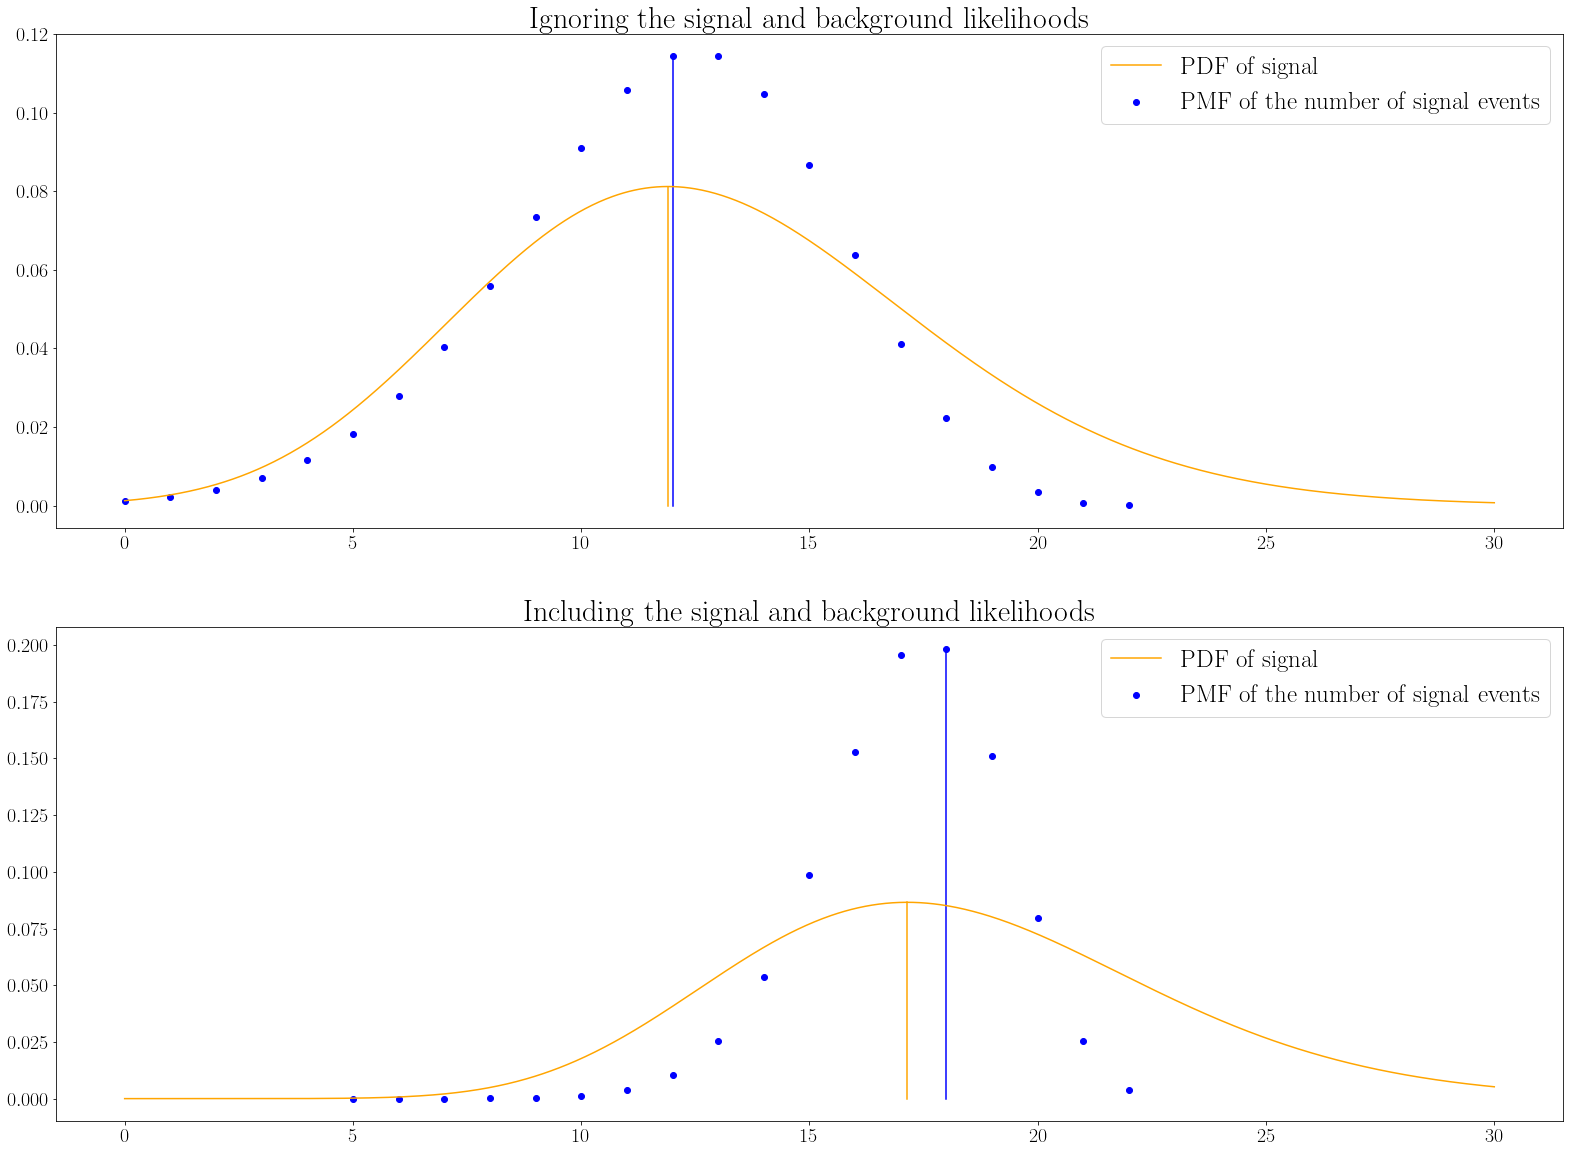

In [263]:
fig, axs = plt.subplots(figsize=(27,20),nrows=2, ncols=1)

ax_ind = 0
# PLOT PMF
axs[ax_ind].scatter( m1.Ns, m1.pmf, label = "PMF of the number of signal events", c="blue")
axs[ax_ind].plot( (m1.mode_pmf,m1.mode_pmf), (0,m1.pmf[m1.Ns==m1.mode_pmf][0]), c="blue")
# PLOT PDF
s = np.linspace(0,30,1000)
axs[ax_ind].plot( s, m1.pdf(s), label = "PDF of signal", c="orange" )
axs[ax_ind].plot( (m1.mode_pdf,m1.mode_pdf), (0,m1.pdf(m1.mode_pdf)), c="orange")
axs[ax_ind].set_title("Ignoring the signal and background likelihoods")
axs[ax_ind].legend()

ax_ind = 1
# PLOT PMF
axs[ax_ind].scatter( m2.Ns, m2.pmf, label = "PMF of the number of signal events", c="blue")
axs[ax_ind].plot( (m2.mode_pmf,m2.mode_pmf), (0,m2.pmf[m2.Ns==m2.mode_pmf][0]), c="blue")
# PLOT PDF
s = np.linspace(0,30,1000)
axs[ax_ind].plot( s, m2.pdf(s), label = "PDF of signal", c="orange" )
axs[ax_ind].plot( (m2.mode_pdf,m2.mode_pdf), (0,m2.pdf(m2.mode_pdf)), c="orange")
axs[ax_ind].set_title("Including the signal and background likelihoods")
axs[ax_ind].legend()

# Some extra features